
# Objective:
1. Use Keras Tuner to Identify Accuracy Score

## Summary: Best Param's Val Accuracy: ~0.8818


# Import Libraries

In [1]:
print('Innit Importing Library...')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dense, Activation, Dropout, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

Innit Importing Library...


# Read Data

In [3]:
print('Innit Reading DataFrame...')
fpath = '/content/mydrive/MyDrive/personal_data/Random_Data/REA/name_gender.csv'
fpath = 'name_gender.csv'
import pandas as pd
df = pd.read_csv(fpath)
print(df.head())
df

Innit Reading DataFrame...
   Unnamed: 0      name gender
0           0  kintrell      M
1           1  quinnell      M
2           2  tylerlee      M
3           3    quincy      M
4           4    slavko      M


,Unnamed: 0,name,gender
0,0,kintrell,M
1,1,quinnell,M
2,2,tylerlee,M
3,3,quincy,M
4,4,slavko,M
...,...,...,...
69437,69437,ikem,M
69438,69438,gradie,M
69439,69439,gaibriel,M
69440,69440,vermont,M


# Clean Data

In [28]:
import re
# string with letters, numbers, and special characters
def clean_letters(s):
    # s = "BuckyBarnes@123"
    # keep only letters
    res = re.sub(r'[^a-zA-Z]', '', s)
    return res
df['name']=df['name'].apply(lambda x: clean_letters(x))
print(len(df))
df.head()

95025


,name,gender
0,Aaban,M
1,Aabha,F
2,Aabid,M
3,Aabriella,F
4,Aada,F


In [29]:
df.drop_duplicates(subset=['name'],inplace=True)

In [30]:
columnsTitles=["name","gender"]
df=df.reindex(columns=columnsTitles)
df['name'] = df['name'].apply(lambda x: str(x).lower())
df = df[[len(e)>1 for e in df.name]]
df = df.drop_duplicates()

names = df['name'].apply(lambda x: x.lower())
gender = df['gender']

df.head()

,name,gender
0,aaban,M
1,aabha,F
2,aabid,M
3,aabriella,F
4,aada,F


In [32]:
maxlen = 20
labels = 2

In [33]:
print("Male : " + str(sum(gender=='M')))
print("Female : " + str(sum(gender=='F')))

Male : 34721
Female : 60304


In [34]:
vocab = set(' '.join([str(i) for i in names]))
vocab.add('END')
len_vocab = len(vocab)

In [35]:
char_index = dict((c, i) for i, c in enumerate(vocab))
char_index

{'s': 0,
 'v': 1,
 'y': 2,
 'p': 3,
 'l': 4,
 ' ': 5,
 'a': 6,
 'e': 7,
 't': 8,
 'd': 9,
 'k': 10,
 'i': 11,
 'm': 12,
 'r': 13,
 'END': 14,
 'w': 15,
 'j': 16,
 'o': 17,
 'f': 18,
 'n': 19,
 'z': 20,
 'h': 21,
 'q': 22,
 'b': 23,
 'u': 24,
 'x': 25,
 'c': 26,
 'g': 27}

In [36]:
X = []
y = []

# Builds an empty line with a 1 at the index of character
def set_flag(i):
    tmp = np.zeros(len_vocab);
    tmp[i] = 1
    return list(tmp)

# Truncate names and create the matrix
def prepare_X(X):
    new_list = []
    trunc_train_name = [str(i)[0:maxlen] for i in X]

    for i in trunc_train_name:
        tmp = [set_flag(char_index[j]) for j in str(i)]
        for k in range(0,maxlen - len(str(i))):
            tmp.append(set_flag(char_index["END"]))
        new_list.append(tmp)

    return new_list


X = prepare_X(names.values)

# Label Encoding of y
def prepare_y(y):
    new_list = []
    for i in y:
        if i == 'M':
            new_list.append([1,0])
        else:
            new_list.append([0,1])

    return new_list

y = prepare_y(gender)

# Train Test Split

In [37]:
x_train, x_test, y_train, y_test = train_test_split(X, y)

# Keras Tuner

In [38]:
! pip install keras-tuner --upgrade

In [39]:
import keras_tuner as kt
from tensorflow import keras

In [43]:
def build_model(hp):
    model = keras.Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32),return_sequences=True, input_shape=(maxlen,len_vocab)))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True))
    model.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32)))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(2, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    return model

In [44]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5)

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json


# Run Tuner's Search for optimal Variable

In [45]:
tuner.search(x_train, y_train, epochs=5, validation_data=(x_test, y_test))
best_model = tuner.get_best_models()[0]

Trial 5 Complete [00h 07m 25s]
val_loss: 10.233842849731445

Best val_loss So Far: 0.2705787420272827
Total elapsed time: 00h 34m 41s
INFO:tensorflow:Oracle triggered exit


# Save Model

In [46]:
best_model.save('best_model_1742022.h5')

In [48]:
prediction = best_model.predict(x_test)

2022-04-17 12:13:28.554189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-17 12:13:28.644305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-17 12:13:28.713582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-17 12:13:28.767145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


# Best Param

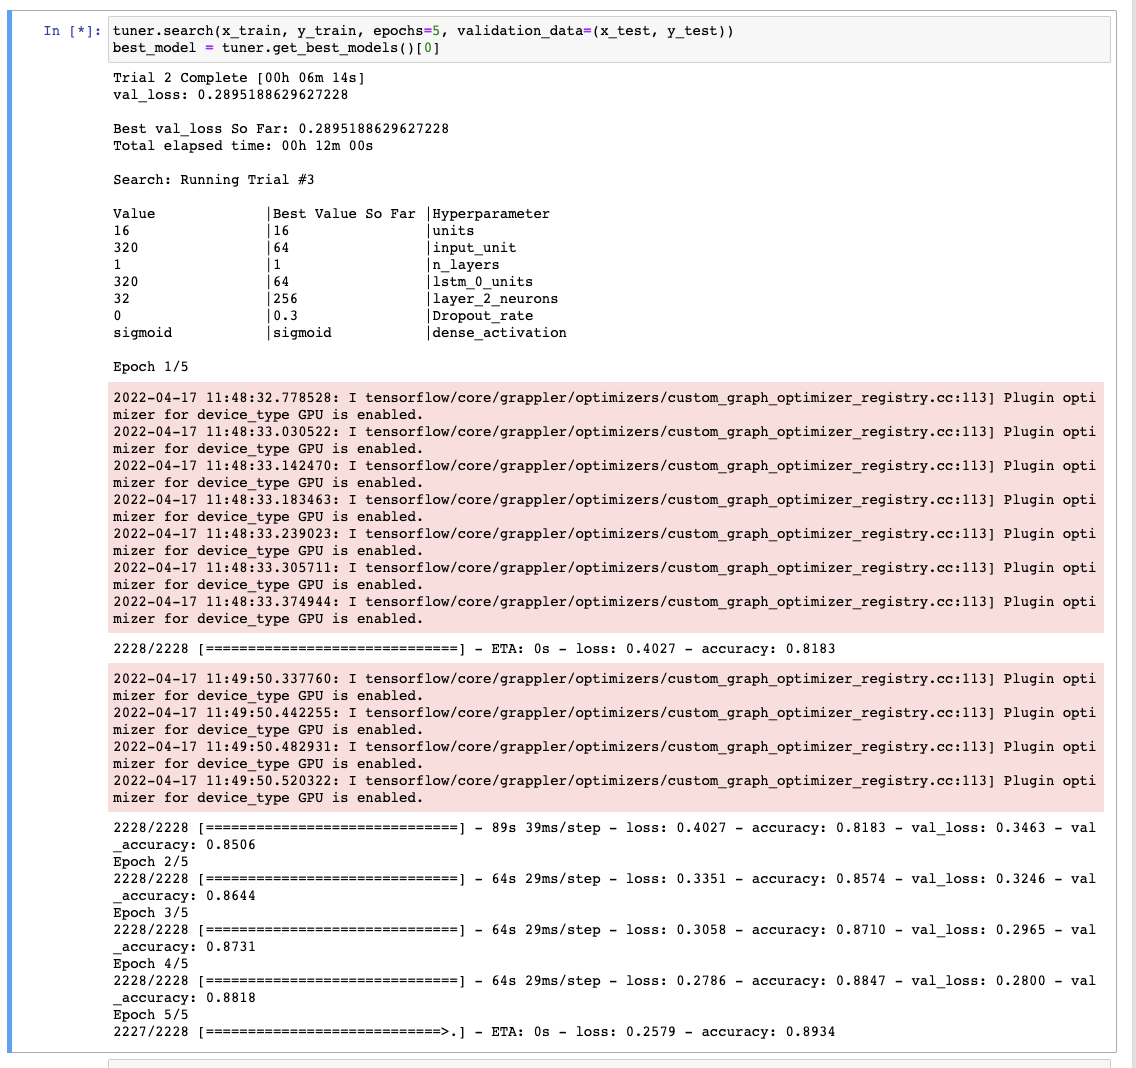

# Best Param's Accuracy: 0.8934